In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import torch
import torch.nn as nn
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from time import time
from torchvision import datasets
from torchinfo import summary
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

In [2]:
BATCH_SIZE = 32
NUM_EPOCHS = 30
LEARNING_RATE = 0.001

In [3]:
dataset_dir = "/work/garbage-classification/"

train_dir = os.path.join(dataset_dir)
classes = os.listdir(dataset_dir)
print(classes)

['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']


In [4]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

dataset = datasets.ImageFolder(dataset_dir, transform=transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

print(f"Total size: {len(dataset)}")

for label in classes:
    directory = os.path.join(train_dir, label)
    print("Images of label \"" + label + "\":\t", len(os.listdir(directory)))

Total size: 2527
Images of label "cardboard":	 403
Images of label "glass":	 501
Images of label "metal":	 410
Images of label "paper":	 594
Images of label "plastic":	 482
Images of label "trash":	 137


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


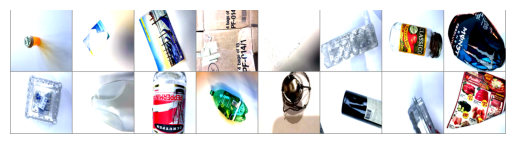

plastic paper paper cardboard paper plastic glass metal plastic plastic glass plastic metal glass plastic paper


In [5]:
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off') 
    plt.show()

dataiter = iter(dataloader)
images, labels = next(dataiter)
imshow(torchvision.utils.make_grid(images[:16]))
print(' '.join('%5s' % classes[labels[j]] for j in range(16)))

In [6]:
targets = dataset.targets
indices = list(range(len(dataset)))

train_indices, temp_indices = train_test_split(indices, test_size=0.3, stratify=targets)
val_indices, test_indices = train_test_split(temp_indices, test_size=0.5, stratify=[targets[i] for i in temp_indices])

train_dataset = Subset(dataset, train_indices)
train_loader = DataLoader(Subset(dataset, train_indices), batch_size=BATCH_SIZE, shuffle=True)
val_dataset = Subset(dataset, val_indices)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_dataset = Subset(dataset, test_indices)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print("Train dataset size:", len(train_dataset))
print("Validation dataset size:", len(val_dataset))
print("Test dataset size:", len(test_dataset))

Train dataset size: 1768
Validation dataset size: 379
Test dataset size: 380


In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

class Model():
    def __init__(self, model : nn.Module, name : str):
        self.model = model.to(device)
        self.name = name

    def eval_f1(self, data_loader, device, best_f1 = False):
        eval_model = self.model
        if (best_f1):
            eval_model.load_state_dict(torch.load(f'best_f1_{self.name}.pth', weights_only=True))

        val_f1 = []
        with torch.no_grad():
            for images, labels in data_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = eval_model(images)
                _, preds = torch.max(outputs, 1)
                f1 = f1_score(labels.cpu(), preds.cpu(), average='macro')
                val_f1.append(f1)
        return sum(val_f1) / len(val_f1)

class ResNet50(Model):
    def __init__(self, num_classes: int) -> None:
        model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)
        model.fc = nn.Linear(model.fc.in_features, num_classes)
        super().__init__(model, "resnet50")

class ResNet50Modify(Model):
    def __init__(self, num_classes: int) -> None:
        model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)
        for param in model.parameters():
            param.requires_grad = False

        new_block = nn.Sequential(
            nn.Conv2d(in_channels=2048, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=64),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=64),
            nn.ReLU(inplace=True),
        )

        layer4_old = model.layer4
        model.layer4 = nn.Sequential(layer4_old, new_block)
        
        model.fc = nn.Linear(64, num_classes)

        for param in model.parameters():
            param.requires_grad = False

        for param in new_block.parameters():
            param.requires_grad = True
        
        for param in model.fc.parameters():
            param.requires_grad = True

        super().__init__(model, "resnet50_add_block_in_end")


class MobileNetV2(Model):
    def __init__(self, num_classes: int) -> None:
        model = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.IMAGENET1K_V2)
        model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
        super().__init__(model, "mobilenet_v2")

class MobileNetV2Modify(Model):
    def __init__(self, num_classes: int) -> None:
        model = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.IMAGENET1K_V2)
        model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
        for param in model.parameters():
            param.requires_grad = False
        for i, param in enumerate(model.parameters()):
            if i < 6:
                param.requires_grad = True  # Разморозить слой
        for param in model.classifier.parameters():
            param.requires_grad = True
        super().__init__(model, "mobilenet_v2_freezing_except_fc")


class EfficientNetB0(Model):
    def __init__(self, num_classes: int) -> None:
        model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.IMAGENET1K_V1)
        model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
        super(EfficientNetB0, self).__init__(model, "efficientnet_b0")

class EfficientNetB0Modify(Model):
    def __init__(self, num_classes: int) -> None:
        model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.IMAGENET1K_V1)
        model.classifier = nn.Sequential(
            nn.Dropout(p=0.5, inplace=True),
            nn.Linear(model.classifier[1].in_features, 512),
            nn.ReLU(),
            nn.Linear(512, num_classes),
        )
        for param in model.parameters():
            param.requires_grad = False
        for param in model.classifier.parameters():
            param.requires_grad = True
        super().__init__(model, "efficientnet_b0_change_last_layer")


class DenseNet121(Model):
    def __init__(self, num_classes: int) -> None:
        model = models.densenet121(weights=models.DenseNet121_Weights.IMAGENET1K_V1)
        model.classifier = nn.Linear(model.classifier.in_features, num_classes)
        super().__init__(model, "densenet121")

class DenseNet121Modify(Model):
    def __init__(self, num_classes: int) -> None:
        model = models.densenet121(weights=models.DenseNet121_Weights.IMAGENET1K_V1)
        for i, layer in enumerate(model.features.children()):
            if i < 6:  # Замораживаем первые 6 блоков
                for param in layer.parameters():
                    param.requires_grad = False
        model.classifier = nn.Linear(model.classifier.in_features, num_classes)
        super().__init__(model, "densenet121_freezing_first_six_layers")

cuda


In [8]:
def train_and_evaluate(model: Model, train_loader, val_loader, num_epochs=NUM_EPOCHS, learning_rate=LEARNING_RATE):
    model_nn = model.model
    optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model_nn.parameters()), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()
    val_f1_stat = []
    best_f1 = 0
    for epoch in range(1, num_epochs + 1):
        model_nn.train()
        start = time()
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model_nn(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        end = time()
        val_f1 = model.eval_f1(val_loader, device)
        if val_f1 > best_f1:
            best_f1 = val_f1
            torch.save(model_nn.state_dict(), f'best_f1_{model.name}.pth')
            print(f"Saved new best model with F1: {best_f1:.2f}")
        val_f1_stat.append(val_f1)
        print(f'Epoch {epoch}: Train time {(end - start):.2f} s, '
              f'Validation F1 {val_f1:.2f}', 
              flush=True)
    return val_f1_stat

In [9]:
test_f1_stat = {}

def run(model : Model):
    val_f1_stat = train_and_evaluate(model, train_loader, val_loader)
    best_test_f1 = model.eval_f1(test_loader, device, True)
    print(f"F1 Test: {best_test_f1:.2f}")
    plt.plot(range(NUM_EPOCHS), val_f1_stat, marker="o")
    plt.title("Validation F1")
    plt.xlabel("epoch")
    plt.ylabel("F1 score")
    plt.show()
    test_f1_stat[model.name] = best_test_f1

In [10]:
summary(ResNet50(len(classes)).model)

Layer (type:depth-idx)                   Param #
ResNet                                   --
├─Conv2d: 1-1                            9,408
├─BatchNorm2d: 1-2                       128
├─ReLU: 1-3                              --
├─MaxPool2d: 1-4                         --
├─Sequential: 1-5                        --
│    └─Bottleneck: 2-1                   --
│    │    └─Conv2d: 3-1                  4,096
│    │    └─BatchNorm2d: 3-2             128
│    │    └─Conv2d: 3-3                  36,864
│    │    └─BatchNorm2d: 3-4             128
│    │    └─Conv2d: 3-5                  16,384
│    │    └─BatchNorm2d: 3-6             512
│    │    └─ReLU: 3-7                    --
│    │    └─Sequential: 3-8              16,896
│    └─Bottleneck: 2-2                   --
│    │    └─Conv2d: 3-9                  16,384
│    │    └─BatchNorm2d: 3-10            128
│    │    └─Conv2d: 3-11                 36,864
│    │    └─BatchNorm2d: 3-12            128
│    │    └─Conv2d: 3-13               

Saved new best model with F1: 0.67
Epoch 1: Train time 11.99 s, Validation F1 0.67
Saved new best model with F1: 0.73
Epoch 2: Train time 11.19 s, Validation F1 0.73
Saved new best model with F1: 0.79
Epoch 3: Train time 9.69 s, Validation F1 0.79
Epoch 4: Train time 9.88 s, Validation F1 0.75
Saved new best model with F1: 0.80
Epoch 5: Train time 9.82 s, Validation F1 0.80
Saved new best model with F1: 0.81
Epoch 6: Train time 9.82 s, Validation F1 0.81
Saved new best model with F1: 0.84
Epoch 7: Train time 9.75 s, Validation F1 0.84
Epoch 8: Train time 9.81 s, Validation F1 0.81
Epoch 9: Train time 9.79 s, Validation F1 0.84
Epoch 10: Train time 9.83 s, Validation F1 0.78
Epoch 11: Train time 9.83 s, Validation F1 0.82
Epoch 12: Train time 9.83 s, Validation F1 0.84
Epoch 13: Train time 9.96 s, Validation F1 0.81
Epoch 14: Train time 9.90 s, Validation F1 0.80
Saved new best model with F1: 0.86
Epoch 15: Train time 9.94 s, Validation F1 0.86
Saved new best model with F1: 0.86
Epoch 1

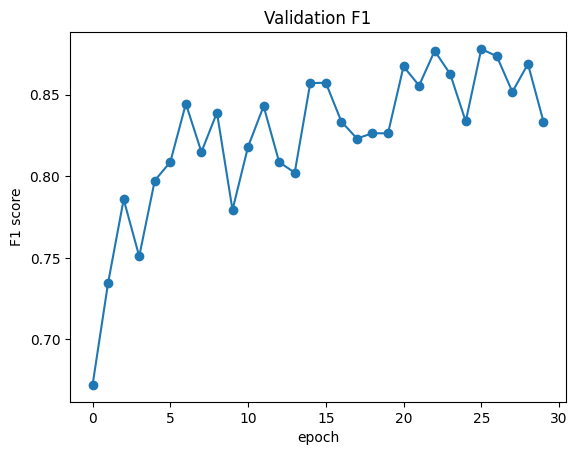

In [11]:
run(ResNet50(len(classes)))

In [12]:
summary(ResNet50Modify(len(classes)).model)

Layer (type:depth-idx)                        Param #
ResNet                                        --
├─Conv2d: 1-1                                 (9,408)
├─BatchNorm2d: 1-2                            (128)
├─ReLU: 1-3                                   --
├─MaxPool2d: 1-4                              --
├─Sequential: 1-5                             --
│    └─Bottleneck: 2-1                        --
│    │    └─Conv2d: 3-1                       (4,096)
│    │    └─BatchNorm2d: 3-2                  (128)
│    │    └─Conv2d: 3-3                       (36,864)
│    │    └─BatchNorm2d: 3-4                  (128)
│    │    └─Conv2d: 3-5                       (16,384)
│    │    └─BatchNorm2d: 3-6                  (512)
│    │    └─ReLU: 3-7                         --
│    │    └─Sequential: 3-8                   (16,896)
│    └─Bottleneck: 2-2                        --
│    │    └─Conv2d: 3-9                       (16,384)
│    │    └─BatchNorm2d: 3-10                 (128)
│    │    └─Con

Saved new best model with F1: 0.81
Epoch 1: Train time 7.27 s, Validation F1 0.81
Saved new best model with F1: 0.85
Epoch 2: Train time 7.36 s, Validation F1 0.85
Saved new best model with F1: 0.87
Epoch 3: Train time 6.66 s, Validation F1 0.87
Epoch 4: Train time 6.26 s, Validation F1 0.86
Epoch 5: Train time 6.17 s, Validation F1 0.86
Epoch 6: Train time 6.14 s, Validation F1 0.86
Saved new best model with F1: 0.88
Epoch 7: Train time 6.18 s, Validation F1 0.88
Epoch 8: Train time 6.19 s, Validation F1 0.86
Epoch 9: Train time 6.82 s, Validation F1 0.85
Epoch 10: Train time 6.21 s, Validation F1 0.87
Epoch 11: Train time 6.19 s, Validation F1 0.85
Epoch 12: Train time 6.22 s, Validation F1 0.86
Epoch 13: Train time 6.19 s, Validation F1 0.85
Saved new best model with F1: 0.89
Epoch 14: Train time 6.77 s, Validation F1 0.89
Epoch 15: Train time 7.27 s, Validation F1 0.86
Epoch 16: Train time 9.25 s, Validation F1 0.88
Epoch 17: Train time 6.86 s, Validation F1 0.88
Epoch 18: Train ti

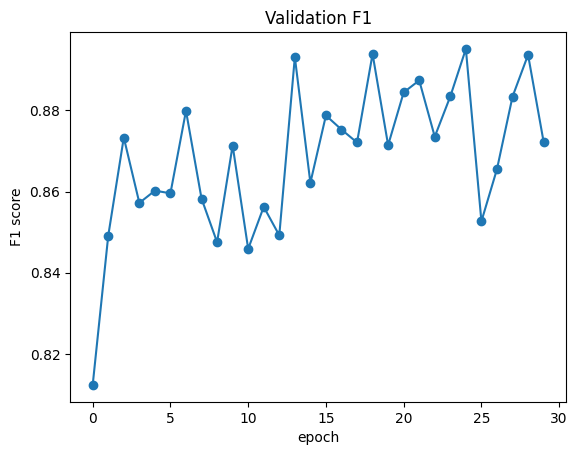

In [13]:
run(ResNet50Modify(len(classes)))

In [14]:
summary(MobileNetV2(len(classes)).model)

Layer (type:depth-idx)                             Param #
MobileNetV2                                        --
├─Sequential: 1-1                                  --
│    └─Conv2dNormActivation: 2-1                   --
│    │    └─Conv2d: 3-1                            864
│    │    └─BatchNorm2d: 3-2                       64
│    │    └─ReLU6: 3-3                             --
│    └─InvertedResidual: 2-2                       --
│    │    └─Sequential: 3-4                        896
│    └─InvertedResidual: 2-3                       --
│    │    └─Sequential: 3-5                        5,136
│    └─InvertedResidual: 2-4                       --
│    │    └─Sequential: 3-6                        8,832
│    └─InvertedResidual: 2-5                       --
│    │    └─Sequential: 3-7                        10,000
│    └─InvertedResidual: 2-6                       --
│    │    └─Sequential: 3-8                        14,848
│    └─InvertedResidual: 2-7                       --
│    │ 

Saved new best model with F1: 0.83
Epoch 1: Train time 8.17 s, Validation F1 0.83
Epoch 2: Train time 8.16 s, Validation F1 0.82
Saved new best model with F1: 0.84
Epoch 3: Train time 8.20 s, Validation F1 0.84
Saved new best model with F1: 0.84
Epoch 4: Train time 7.40 s, Validation F1 0.84
Epoch 5: Train time 7.18 s, Validation F1 0.82
Saved new best model with F1: 0.86
Epoch 6: Train time 7.22 s, Validation F1 0.86
Saved new best model with F1: 0.88
Epoch 7: Train time 7.17 s, Validation F1 0.88
Epoch 8: Train time 6.99 s, Validation F1 0.86
Epoch 9: Train time 7.03 s, Validation F1 0.85
Epoch 10: Train time 7.06 s, Validation F1 0.85
Epoch 11: Train time 7.22 s, Validation F1 0.85
Saved new best model with F1: 0.88
Epoch 12: Train time 7.36 s, Validation F1 0.88
Epoch 13: Train time 7.32 s, Validation F1 0.86
Epoch 14: Train time 7.03 s, Validation F1 0.82
Saved new best model with F1: 0.90
Epoch 15: Train time 7.26 s, Validation F1 0.90
Epoch 16: Train time 7.10 s, Validation F1 0

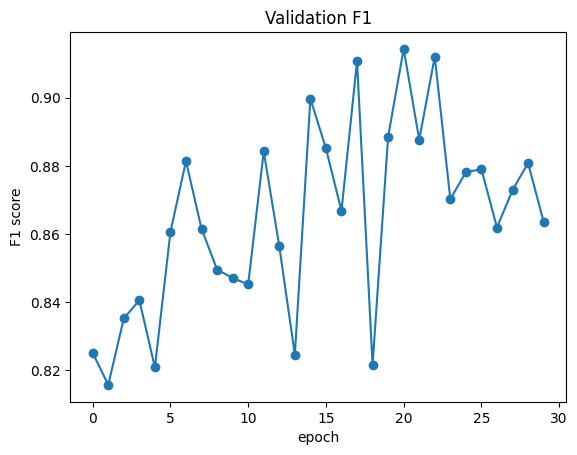

In [15]:
run(MobileNetV2(len(classes)))

In [16]:
summary(MobileNetV2Modify(len(classes)).model)

Layer (type:depth-idx)                             Param #
MobileNetV2                                        --
├─Sequential: 1-1                                  --
│    └─Conv2dNormActivation: 2-1                   --
│    │    └─Conv2d: 3-1                            864
│    │    └─BatchNorm2d: 3-2                       64
│    │    └─ReLU6: 3-3                             --
│    └─InvertedResidual: 2-2                       --
│    │    └─Sequential: 3-4                        896
│    └─InvertedResidual: 2-3                       --
│    │    └─Sequential: 3-5                        (5,136)
│    └─InvertedResidual: 2-4                       --
│    │    └─Sequential: 3-6                        (8,832)
│    └─InvertedResidual: 2-5                       --
│    │    └─Sequential: 3-7                        (10,000)
│    └─InvertedResidual: 2-6                       --
│    │    └─Sequential: 3-8                        (14,848)
│    └─InvertedResidual: 2-7                       --

Saved new best model with F1: 0.61
Epoch 1: Train time 8.79 s, Validation F1 0.61
Saved new best model with F1: 0.71
Epoch 2: Train time 8.75 s, Validation F1 0.71
Saved new best model with F1: 0.78
Epoch 3: Train time 9.14 s, Validation F1 0.78
Epoch 4: Train time 8.88 s, Validation F1 0.72
Epoch 5: Train time 8.03 s, Validation F1 0.75
Epoch 6: Train time 6.87 s, Validation F1 0.75
Epoch 7: Train time 7.88 s, Validation F1 0.76
Epoch 8: Train time 7.88 s, Validation F1 0.76
Epoch 9: Train time 7.72 s, Validation F1 0.76
Epoch 10: Train time 8.10 s, Validation F1 0.78
Saved new best model with F1: 0.79
Epoch 11: Train time 8.00 s, Validation F1 0.79
Saved new best model with F1: 0.79
Epoch 12: Train time 7.87 s, Validation F1 0.79
Saved new best model with F1: 0.81
Epoch 13: Train time 7.69 s, Validation F1 0.81
Epoch 14: Train time 6.66 s, Validation F1 0.80
Epoch 15: Train time 8.16 s, Validation F1 0.79
Epoch 16: Train time 7.79 s, Validation F1 0.77
Saved new best model with F1: 0

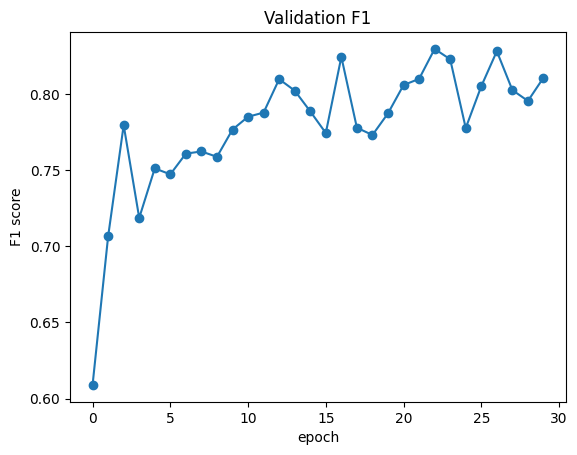

In [17]:
run(MobileNetV2Modify(len(classes)))

In [18]:
summary(EfficientNetB0(len(classes)).model)

Layer (type:depth-idx)                                  Param #
EfficientNet                                            --
├─Sequential: 1-1                                       --
│    └─Conv2dNormActivation: 2-1                        --
│    │    └─Conv2d: 3-1                                 864
│    │    └─BatchNorm2d: 3-2                            64
│    │    └─SiLU: 3-3                                   --
│    └─Sequential: 2-2                                  --
│    │    └─MBConv: 3-4                                 1,448
│    └─Sequential: 2-3                                  --
│    │    └─MBConv: 3-5                                 6,004
│    │    └─MBConv: 3-6                                 10,710
│    └─Sequential: 2-4                                  --
│    │    └─MBConv: 3-7                                 15,350
│    │    └─MBConv: 3-8                                 31,290
│    └─Sequential: 2-5                                  --
│    │    └─MBConv: 3-9         

Saved new best model with F1: 0.81
Epoch 1: Train time 10.12 s, Validation F1 0.81
Epoch 2: Train time 10.13 s, Validation F1 0.79
Saved new best model with F1: 0.84
Epoch 3: Train time 9.89 s, Validation F1 0.84
Epoch 4: Train time 7.88 s, Validation F1 0.84
Saved new best model with F1: 0.85
Epoch 5: Train time 8.97 s, Validation F1 0.85
Epoch 6: Train time 9.50 s, Validation F1 0.83
Epoch 7: Train time 9.80 s, Validation F1 0.84
Saved new best model with F1: 0.90
Epoch 8: Train time 9.42 s, Validation F1 0.90
Epoch 9: Train time 8.26 s, Validation F1 0.83
Epoch 10: Train time 8.22 s, Validation F1 0.85
Epoch 11: Train time 8.13 s, Validation F1 0.85
Epoch 12: Train time 8.36 s, Validation F1 0.88
Epoch 13: Train time 8.32 s, Validation F1 0.90
Epoch 14: Train time 8.24 s, Validation F1 0.88
Epoch 15: Train time 8.22 s, Validation F1 0.88
Epoch 16: Train time 8.28 s, Validation F1 0.85
Epoch 17: Train time 8.20 s, Validation F1 0.86
Epoch 18: Train time 9.07 s, Validation F1 0.86
Epo

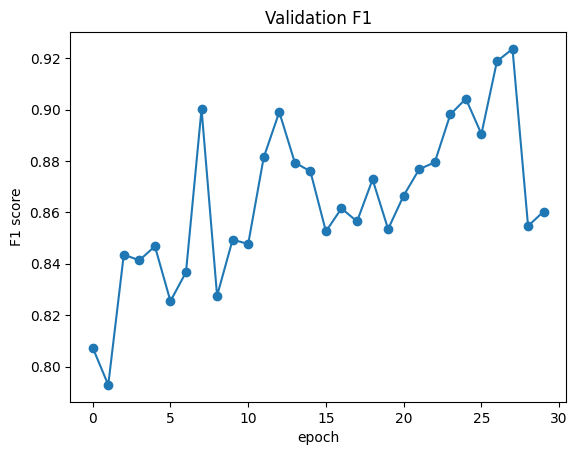

In [19]:
run(EfficientNetB0(len(classes)))

In [20]:
summary(EfficientNetB0Modify(len(classes)).model)

Layer (type:depth-idx)                                  Param #
EfficientNet                                            --
├─Sequential: 1-1                                       --
│    └─Conv2dNormActivation: 2-1                        --
│    │    └─Conv2d: 3-1                                 (864)
│    │    └─BatchNorm2d: 3-2                            (64)
│    │    └─SiLU: 3-3                                   --
│    └─Sequential: 2-2                                  --
│    │    └─MBConv: 3-4                                 (1,448)
│    └─Sequential: 2-3                                  --
│    │    └─MBConv: 3-5                                 (6,004)
│    │    └─MBConv: 3-6                                 (10,710)
│    └─Sequential: 2-4                                  --
│    │    └─MBConv: 3-7                                 (15,350)
│    │    └─MBConv: 3-8                                 (31,290)
│    └─Sequential: 2-5                                  --
│    │    └─MBConv

Saved new best model with F1: 0.62
Epoch 1: Train time 7.55 s, Validation F1 0.62
Saved new best model with F1: 0.75
Epoch 2: Train time 6.64 s, Validation F1 0.75
Epoch 3: Train time 7.82 s, Validation F1 0.68
Saved new best model with F1: 0.76
Epoch 4: Train time 6.85 s, Validation F1 0.76
Epoch 5: Train time 6.72 s, Validation F1 0.73
Epoch 6: Train time 6.74 s, Validation F1 0.73
Epoch 7: Train time 6.73 s, Validation F1 0.76
Epoch 8: Train time 6.62 s, Validation F1 0.75
Saved new best model with F1: 0.78
Epoch 9: Train time 6.67 s, Validation F1 0.78
Epoch 10: Train time 6.70 s, Validation F1 0.74
Epoch 11: Train time 6.92 s, Validation F1 0.73
Epoch 12: Train time 6.75 s, Validation F1 0.75
Saved new best model with F1: 0.82
Epoch 13: Train time 6.68 s, Validation F1 0.82
Epoch 14: Train time 6.75 s, Validation F1 0.75
Epoch 15: Train time 6.62 s, Validation F1 0.75
Epoch 16: Train time 6.83 s, Validation F1 0.79
Epoch 17: Train time 6.68 s, Validation F1 0.80
Epoch 18: Train ti

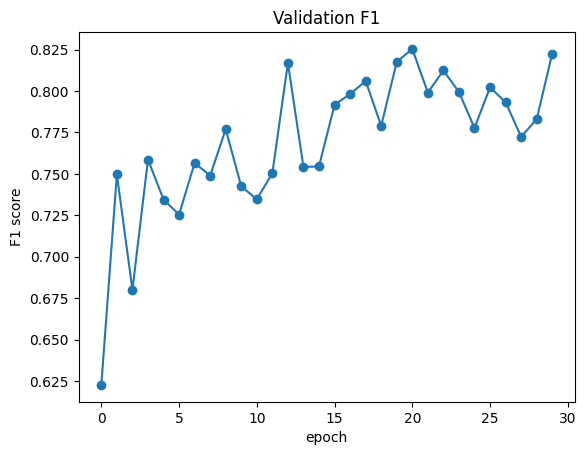

In [21]:
run(EfficientNetB0Modify(len(classes)))

In [22]:
summary(DenseNet121(len(classes)).model)

Layer (type:depth-idx)                   Param #
DenseNet                                 --
├─Sequential: 1-1                        --
│    └─Conv2d: 2-1                       9,408
│    └─BatchNorm2d: 2-2                  128
│    └─ReLU: 2-3                         --
│    └─MaxPool2d: 2-4                    --
│    └─_DenseBlock: 2-5                  --
│    │    └─_DenseLayer: 3-1             45,440
│    │    └─_DenseLayer: 3-2             49,600
│    │    └─_DenseLayer: 3-3             53,760
│    │    └─_DenseLayer: 3-4             57,920
│    │    └─_DenseLayer: 3-5             62,080
│    │    └─_DenseLayer: 3-6             66,240
│    └─_Transition: 2-6                  --
│    │    └─BatchNorm2d: 3-7             512
│    │    └─ReLU: 3-8                    --
│    │    └─Conv2d: 3-9                  32,768
│    │    └─AvgPool2d: 3-10              --
│    └─_DenseBlock: 2-7                  --
│    │    └─_DenseLayer: 3-11            53,760
│    │    └─_DenseLayer: 3-12     

Saved new best model with F1: 0.68
Epoch 1: Train time 13.94 s, Validation F1 0.68
Saved new best model with F1: 0.77
Epoch 2: Train time 13.54 s, Validation F1 0.77
Saved new best model with F1: 0.79
Epoch 3: Train time 13.47 s, Validation F1 0.79
Saved new best model with F1: 0.80
Epoch 4: Train time 12.76 s, Validation F1 0.80
Epoch 5: Train time 13.10 s, Validation F1 0.79
Saved new best model with F1: 0.84
Epoch 6: Train time 12.39 s, Validation F1 0.84
Saved new best model with F1: 0.86
Epoch 7: Train time 12.33 s, Validation F1 0.86
Epoch 8: Train time 12.46 s, Validation F1 0.86
Epoch 9: Train time 12.30 s, Validation F1 0.85
Saved new best model with F1: 0.87
Epoch 10: Train time 12.24 s, Validation F1 0.87
Epoch 11: Train time 12.41 s, Validation F1 0.78
Epoch 12: Train time 13.25 s, Validation F1 0.80
Epoch 13: Train time 13.16 s, Validation F1 0.80
Epoch 14: Train time 13.34 s, Validation F1 0.85
Epoch 15: Train time 13.37 s, Validation F1 0.84
Epoch 16: Train time 13.65 s,

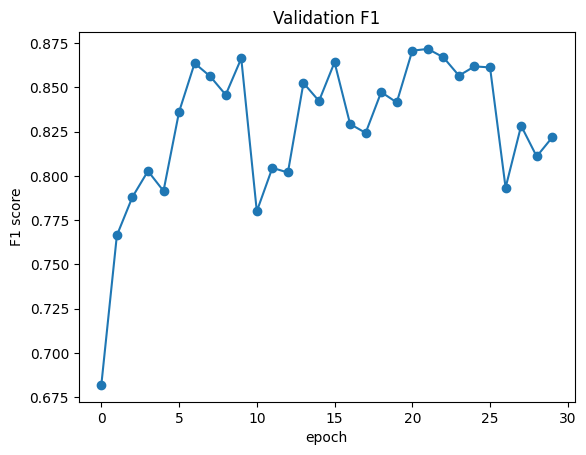

In [23]:
run(DenseNet121(len(classes)))

In [24]:
summary(DenseNet121Modify(len(classes)).model)

Layer (type:depth-idx)                   Param #
DenseNet                                 --
├─Sequential: 1-1                        --
│    └─Conv2d: 2-1                       (9,408)
│    └─BatchNorm2d: 2-2                  (128)
│    └─ReLU: 2-3                         --
│    └─MaxPool2d: 2-4                    --
│    └─_DenseBlock: 2-5                  --
│    │    └─_DenseLayer: 3-1             (45,440)
│    │    └─_DenseLayer: 3-2             (49,600)
│    │    └─_DenseLayer: 3-3             (53,760)
│    │    └─_DenseLayer: 3-4             (57,920)
│    │    └─_DenseLayer: 3-5             (62,080)
│    │    └─_DenseLayer: 3-6             (66,240)
│    └─_Transition: 2-6                  --
│    │    └─BatchNorm2d: 3-7             (512)
│    │    └─ReLU: 3-8                    --
│    │    └─Conv2d: 3-9                  (32,768)
│    │    └─AvgPool2d: 3-10              --
│    └─_DenseBlock: 2-7                  --
│    │    └─_DenseLayer: 3-11            53,760
│    │    └─_D

Saved new best model with F1: 0.77
Epoch 1: Train time 13.10 s, Validation F1 0.77
Saved new best model with F1: 0.81
Epoch 2: Train time 12.50 s, Validation F1 0.81
Epoch 3: Train time 12.81 s, Validation F1 0.78
Epoch 4: Train time 12.97 s, Validation F1 0.80
Saved new best model with F1: 0.86
Epoch 5: Train time 13.34 s, Validation F1 0.86
Saved new best model with F1: 0.87
Epoch 6: Train time 13.05 s, Validation F1 0.87
Epoch 7: Train time 11.76 s, Validation F1 0.87
Epoch 8: Train time 12.99 s, Validation F1 0.87
Saved new best model with F1: 0.88
Epoch 9: Train time 12.17 s, Validation F1 0.88
Epoch 10: Train time 12.71 s, Validation F1 0.82
Epoch 11: Train time 11.88 s, Validation F1 0.87
Epoch 12: Train time 12.66 s, Validation F1 0.86
Epoch 13: Train time 13.70 s, Validation F1 0.86
Epoch 14: Train time 13.08 s, Validation F1 0.87
Epoch 15: Train time 13.23 s, Validation F1 0.88
Epoch 16: Train time 11.44 s, Validation F1 0.83
Saved new best model with F1: 0.89
Epoch 17: Train

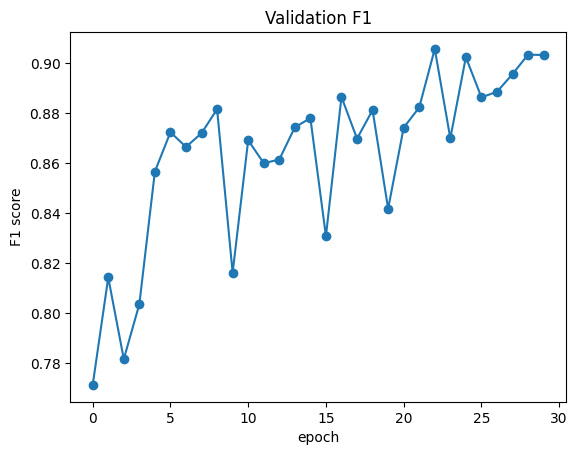

In [25]:
run(DenseNet121Modify(len(classes)))

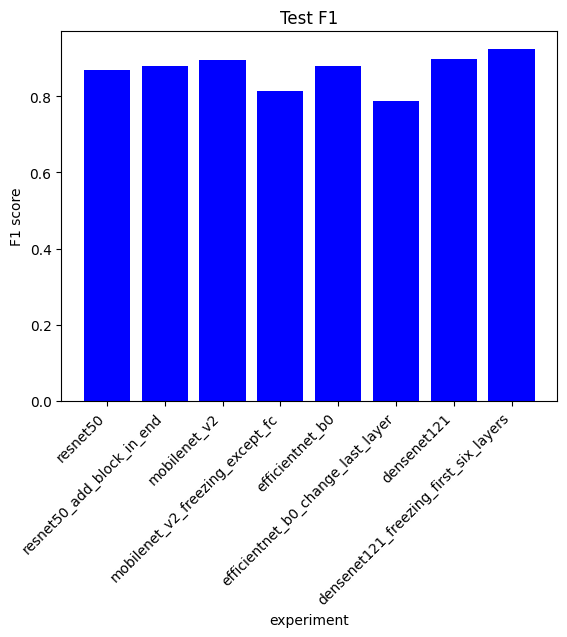

In [26]:
keys = [*test_f1_stat.keys()]
f1_scores = [*test_f1_stat.values()]
plt.bar(keys, f1_scores, color="blue")
plt.xlabel("experiment")
plt.ylabel("F1 score")
plt.title("Test F1")
plt.xticks(rotation=45, ha="right")
plt.show()